In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model='LSTM'#'RF'#'XGB'   # 'LSTM'
scores=pd.read_csv('art1000_'+model+'_acc_time.csv')[:10] # Brute force metering for all the series through all the levels 
scores

,level,time,000,001,002,003,004,005,006,007,...,990,991,992,993,994,995,996,997,998,999
0,0,7811.454789,0.920467,0.947217,1.042106,1.448483,0.910320,1.127565,0.898132,1.379154,...,10.942434,23.509465,6.755895,8.432639,9.509990,2.106125,15.833097,10.237217,23.080778,6.540122
1,1,7608.982551,0.474167,0.508843,0.743566,0.596222,1.238942,2.169516,0.639134,2.407580,...,10.517475,22.472203,7.713435,8.954473,9.040197,2.253868,13.165007,12.107271,24.179171,5.128373
2,2,7904.843854,0.992377,0.538004,2.327874,3.223064,0.652893,1.458607,1.224507,0.930547,...,9.633485,28.236085,7.128702,8.882158,11.386283,2.623377,15.314550,10.772417,22.410517,3.988277
3,3,8105.009564,2.884480,2.480241,0.564425,0.325066,3.937556,1.817790,0.746813,0.942862,...,9.483674,26.500329,9.499603,7.997117,8.278523,2.198934,13.515670,9.915788,22.990962,11.396834
4,4,8443.904852,1.825809,0.240279,0.286317,0.336762,0.403236,0.873413,1.072736,0.945329,...,9.186414,30.235363,8.350286,7.608048,9.186995,2.582528,13.452650,9.682066,20.664735,5.036209
5,5,8750.566988,2.092751,0.417198,0.727181,3.142845,0.424578,3.368696,2.324905,0.654594,...,9.680365,29.132436,9.443740,7.929952,9.830713,3.508321,11.803991,10.567691,26.167338,5.947412
6,6,9061.937356,2.295331,0.880863,1.088594,0.479611,0.349622,0.924334,0.473205,5.629156,...,9.755867,29.401189,9.658578,7.876073,20.422041,2.377154,12.899685,9.756617,22.627154,6.823822
7,7,9236.844326,1.674324,0.225113,3.093992,0.389268,0.498777,1.235682,1.182849,1.932789,...,9.028440,28.110978,9.405151,7.662334,11.632044,2.461969,11.919716,10.135268,23.391176,5.190974
8,8,9390.804332,0.811619,0.218174,0.204540,0.406336,1.355811,1.587531,0.336540,1.459458,...,12.610545,27.996961,9.313283,7.462451,8.905169,3.399913,18.289630,10.177191,24.556883,8.748188
9,9,9680.314631,1.493269,0.518956,0.364889,1.722679,0.869446,1.950384,0.494552,0.672744,...,8.896123,23.902407,8.581124,7.555234,11.606134,4.273806,11.929559,10.473853,21.452965,5.675164


In [3]:
scores.time.sum()

85994.66324305534

In [4]:
nlevel=10
def seconds_to_str(seconds):
    mm, ss = divmod(seconds, 60)
    hh, mm = divmod(mm, 60)
    return "%02d:%02d:%02d" % (hh, mm, ss)

''' делаем таблицу, ставим метки'''
def mark(quant, strategy='Quantile'):
    #print('Quantille =', quant)
    labels=pd.DataFrame(columns=['series', 'level'])
    allser=scores.columns[2:]#.tolist()
    labels.series=allser
    quality=[10]*nlevel#[5,5,5,5,5]
    if strategy=='Quantity':
        allser=scores.columns[2:]#.tolist()
        labels.series=allser
        a={}
        for i in range(nlevel):
            labels['score%i'%i]=scores.loc[i, allser].values
        for i in range(nlevel):
            a[i]=labels[labels['score%i'%i].rank(method='dense') <= quant].series.values
            labels=labels.drop(labels[labels['score%i'%i].rank(method='dense') <= quant].index)
        a[nlevel]=labels.series.values
        labels=pd.DataFrame(columns=['series', 'level'])
        allser=scores.columns[2:]#.tolist()
        labels.series=allser
        for i in a.keys():
            labels.loc[labels.series.isin(a[i]), 'level']=i
        for i in range(nlevel):
            labels['score%i'%i]=scores.loc[i, allser].values
        labels['result']=np.zeros(len(labels))
        for i in range(nlevel):
            ind=labels[labels.level==i].index
            labels.loc[ind, 'result']=labels['score%i'%i][ind]
    else:
        for i in range(nlevel):
            s=scores.loc[i, allser].values
            if strategy=='Quantile':
                b=np.quantile(s, quant)
            else:
                b=quant
            j=np.where(s<=b)[0]
            #print('level %i - quantile %.3f: %i items'%(i, b, len(j)))
            labels.iloc[labels.index[labels.series.isin(allser[j]).tolist()], 1]=i
            allser=np.delete(allser,j)
        labels=labels.fillna(value=nlevel)
        allser=scores.columns[2:]
        for i in range(nlevel):
            labels['score%i'%i]=scores.loc[i, allser].values
        cols=['score%i'%i for i in range(nlevel)]
        labels['result']=np.zeros(len(labels))
        for i in range(nlevel):
            ind=labels[labels.level==i].index
            labels.loc[ind, 'result']=labels['score%i'%i][ind]
    return labels

''' решето - считаем прошедших/оставшихся'''
def seive(quant, labels, strategy='Quantile'):
    l1,l2=[],[]
    lab=labels.copy()
    if strategy=='Quantity':
        for i in range(nlevel):
            col='score%i'%i
            l1.append(labels[labels.level==i][col].values)
            l2.append(labels[labels.level>i][col].values)
#         i=nlevel
#         col='score%i'%(nlenel-1)
#         l1.append(labels[labels.level==i][col].values)
#         l2.append(labels[labels.level==i][col].values)
    else:
        for i in range(nlevel):
            col='score%i'%i
            if strategy=='Quantile':
                b=np.quantile(lab[col].values, quant)
            else:
                b=quant          
            seived=lab[lab[col]<=b][col]
            worst=lab[lab[col]>b][col]
            l1.append(seived.values)
            l2.append(worst.values)
            lab=lab.drop(seived.index)
    return l1, l2 #l1 - dropped, l2 - remain

'''собираем время/ошибки'''
def make_acc_time(strategy):
    acc_time=pd.DataFrame(columns=(['quant', 'time', 'residual']+['score%i'%i for i in range(nlevel)]+['worst']))
    if strategy=='Quantile':
        qu=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    elif strategy=='Level':
        qu=np.arange(2,22,2)#[2.5,5.,7.5,10,12.5,15,17.5, 20, 22.5, 25]
    else:
        qu=[10,20,30,40,50,60,70,80,90,100]

    acc_time.quant=qu
    for n,q in enumerate(qu):
        labels=mark(q, strategy=strategy)
        cols=['score%i'%i for i in range(nlevel)]
        seived=seive(q, labels, strategy=strategy)
        amns=np.array([len(scores.columns)-2-sum([len(i) for i in seived[0][:j]]) for j in range(nlevel)]) #amount of series passed to the level
        tms=scores.time.values/len(labels) #time for 1 series on each level
        t=amns.dot(tms)
        acc_time.loc[n,'time']=t
        acc_time.loc[n,'residual']=len(seived[1][nlevel-1])
        acc_time.loc[n,cols]=[np.mean(i) if len(i) else np.nan for i in seived[0]] #gr[cols].mean(axis=1).values
        acc_time.loc[n,'worst']=np.mean(seived[1][nlevel-1]) if len(seived[1][nlevel-1]) else np.nan
        #print(seconds_to_str(t))
    return acc_time

Quantile strategy benefit 49.75%
Level strategy benefit 64.64%
Quantity strategy benefit 15.83%


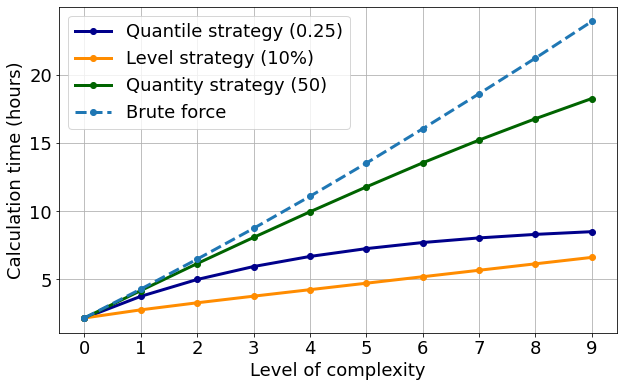

In [13]:
color=['darkblue', 'darkorange', 'darkgreen']
form=['%.2f', '%.0f%%','%i']
if model=='LSTM':
    t_unit=3600  
elif model=='XGB':
    t_unit=60
else: t_unit=60
integr={}
plt.figure(figsize=(10,6))
for k,strategy in enumerate(['Quantile','Level', 'Quantity']):
    if strategy=='Quantile':
        qu=0.25
    elif strategy=='Level':
        qu=10
    else:
        qu=50
    tms=[]
    bf=[]
    labels=mark(qu, strategy=strategy)
    t=0
    for i in range(nlevel):
        t+=(len(scores.columns[2:])-len(labels[labels.level<i]))*scores.loc[i, 'time'].sum()/len(scores.columns[2:])
        tms.append(t/t_unit)
        bf.append(sum(scores.time.values[:i+1]))
    plt.plot(tms, color=color[k], lw=3, label=strategy+' strategy ('+form[k]%qu+')', marker='o')
    integr[strategy]=sum(tms)
plt.plot(np.array(bf)/t_unit, lw=3, ls='--', label='Brute force', marker='o')
if t_unit==1:
    plt.ylabel('Calculation time (seconds)', size=18)
elif t_unit==60:
    plt.ylabel('Calculation time (minutes)', size=18)
else: 
    plt.ylabel('Calculation time (hours)', size=18)
plt.yticks(size=18)
plt.xticks(np.arange(nlevel), size=18)
plt.xlabel('Level of complexity', size=18)
plt.legend(fontsize=18)
plt.grid()
#plt.savefig('newpic/'+model+'_timing.png', dpi=300, format='png' )
for i in integr.keys():
    print(i + ' strategy benefit %.2f%%'%(100-integr[i]/sum(np.array(bf)/t_unit)*100))

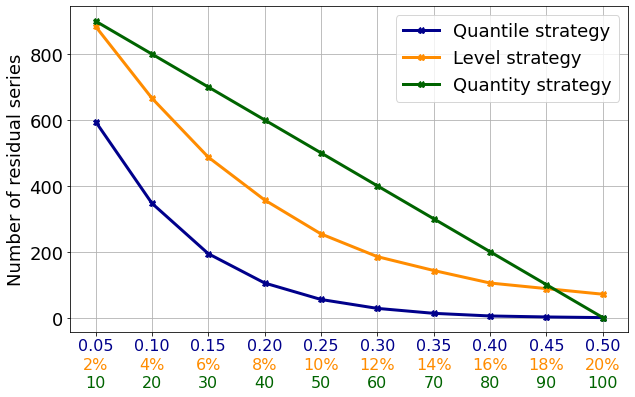

In [162]:
'''Painting'''
color=['darkblue', 'darkorange', 'darkgreen']
form=['%.2f', '%.0f%%','%i']
plt.figure(figsize=(10,6))
for k,strategy in enumerate(['Quantile','Level', 'Quantity']):
    if model=='LSTM':
        t_unit=3600  
    elif model=='XGB':
        t_unit=60
    else: t_unit=60
    acc_time=make_acc_time(strategy)
    if strategy=='Quantile':
        xlab='Quantile to drop'
    elif strategy=='Level':
        xlab='Fixed sMAPE value'
    else:
        xlab='Amount of seived series'
    plt.plot(acc_time.residual, c=color[k], lw=3, label=strategy+' strategy', marker='X')
    plt.ylabel('Number of residual series', size=18)
    for i in acc_time.index:
        plt.text(i, -100-k*55, form[k]%(acc_time.quant)[i], color=color[k], size=16, ha='center')
    #plt.xticks(acc_time.index, acc_time.quant, size=18)
plt.xticks(acc_time.index, [])
plt.yticks(size=18)
#plt.xlabel(xlab, size=18)
plt.legend(fontsize=18)
plt.grid(axis='both')
#plt.savefig('newpic/RF_resid.png', dpi=300, format='png' )

In [146]:
acc_time

,quant,time,residual,score0,score1,score2,score3,score4,score5,score6,score7,score8,score9,worst
0,10,81929.253703,900,0.971769,0.855671,0.828973,0.799329,0.993908,1.136514,1.316975,1.484798,1.515279,1.493151,10.101838
1,20,77863.844162,800,1.133419,1.013951,1.218768,1.238682,1.432585,1.755974,1.958742,2.062559,2.106261,2.2648,10.825433
2,30,73798.434622,700,1.247521,1.306656,1.54025,1.710732,1.788961,2.074513,2.368286,2.497127,2.837238,3.195624,11.67503
3,40,69733.025081,600,1.350639,1.463287,1.740843,2.003953,2.177985,2.463421,2.74409,3.076452,3.196207,4.072263,12.781727
4,50,65667.615541,500,1.449005,1.601358,2.019352,2.286363,2.461017,2.93595,3.219798,3.693815,4.093348,4.93981,14.084486
5,60,61602.206,400,1.536182,1.724708,2.237126,2.518333,2.773155,3.423568,3.859643,4.434458,4.877166,5.805887,15.706359
6,70,57536.79646,300,1.611581,1.888004,2.356148,2.749889,3.173546,4.011949,4.344215,5.377641,5.945285,7.391788,18.093921
7,80,53471.386919,200,1.675285,2.0489,2.493706,3.044123,3.528054,4.338796,5.273845,6.355695,7.721287,9.532102,21.765508
8,90,49405.977379,100,1.738184,2.151536,2.71038,3.35609,3.925628,4.987898,6.002208,7.760994,9.374967,13.295783,28.810569
9,100,45340.567838,0,1.802989,2.314987,2.901069,3.630555,4.416021,5.535987,6.991063,9.454519,13.075681,27.512312,NaN


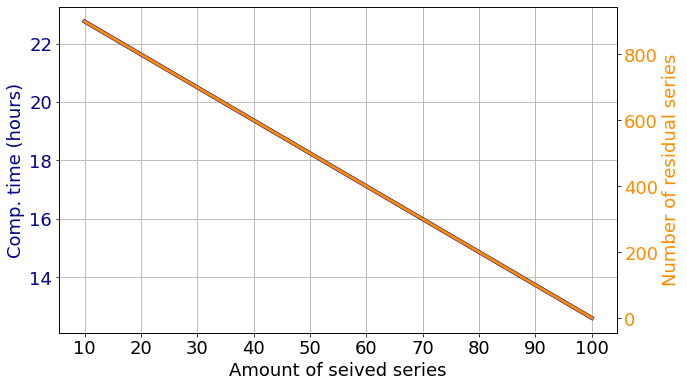

In [112]:
ax1=plt.subplot(1,1,1)
ax1.plot(acc_time.time/t_unit, c='darkblue', lw=4)
ax1.set_xticks(acc_time.index)
ax1.set_xticklabels(acc_time.quant.values, size=18)
ax1.set_xlabel(xlab, size=18)
if t_unit==1:
    ax1.set_ylabel('Comp. time (seconds)', c='darkblue', size=18)
elif t_unit==60:
    ax1.set_ylabel('Comp. time (minutes)', c='darkblue', size=18)
else:
    ax1.set_ylabel('Comp. time (hours)', c='darkblue', size=18)
ax1.tick_params(axis='y', labelcolor='darkblue', labelsize=18)
ax1.grid()

ax2=ax1.twinx()
ax2.plot(acc_time.residual, c='darkorange', lw=3)
ax2.set_ylabel('Number of residual series',c='darkorange', size=18)
ax2.tick_params(axis='y', labelcolor='darkorange', labelsize=18)
#plt.legend(['Time', 'Number'], fontsize=14)
#plt.savefig('newpic/LSTM_time_res.png', dpi=300, format='png' )
plt.show()

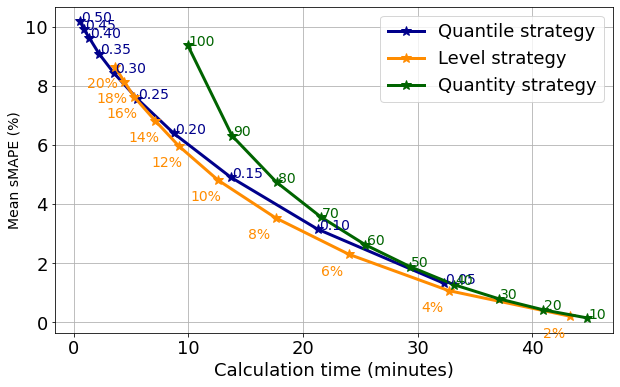

In [164]:
'''All in one'''
plt.figure(figsize=(10,6))
color=['darkblue', 'darkorange', 'darkgreen']
for k,strategy in enumerate(['Quantile','Level', 'Quantity']):
    if strategy=='Quantile':
        qu=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
        form='%.2f'
    elif strategy=='Level':
        qu=np.arange(2,21,2)#[2.5,5.,7.5,10,12.5,15,17.5, 20, 22.5, 25]
        form='%.0f%%'
    else:
        qu=[10,20,30,40,50,60,70,80,90,100]
        form='%i'
    err=[]
    for n,q in enumerate(qu):
        labels=mark(q, strategy=strategy) 
        err.append(labels['result'].mean())
    acc_time=make_acc_time(strategy)
    plt.plot(acc_time.time/t_unit, err, marker='*', markersize=10, lw=3, label=strategy+' strategy', c=color[k])
    for i, xy in enumerate(zip(acc_time.time.values/t_unit-k%2*2.5+.1, np.array(err)-k%2*.7)):
        plt.text(xy[0],xy[1], form%qu[i], size=14, c=color[k])
    #plt.xticks(acc_time.index, acc_time.quant)
if t_unit==1:
    plt.xlabel('Calculation time (seconds)', size=18)
elif t_unit==60:
    plt.xlabel('Calculation time (minutes)', size=18)
else: 
    plt.xlabel('Calculation time (hours)', size=18)
plt.ylabel('Mean sMAPE (%)', size=14)
#plt.title('sMAPE on time  for strategies (excluding residuals)', size=16)
plt.legend(fontsize=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid()
#plt.savefig('newpic/RF_acc_time.png', dpi=300, format='png' )
plt.show()

In [165]:
make_acc_time('Quantity')

,quant,time,residual,score0,score1,score2,score3,score4,score5,score6,score7,score8,score9,worst
0,10,2687.836114,900,1.247301,1.17147,1.060137,1.255657,1.047098,1.26314,1.45701,1.616961,1.773265,1.942457,10.122797
1,20,2455.463142,800,1.432209,1.559866,1.570104,1.740469,1.851225,2.028106,2.308086,2.492856,2.771853,3.028105,11.062855
2,30,2223.090171,700,1.655839,1.894339,1.909474,2.203625,2.275267,2.675261,3.016469,3.233876,3.501607,3.95366,12.127511
3,40,1990.717199,600,1.851256,2.127476,2.248656,2.563379,2.753319,3.174023,3.558299,3.960206,4.445454,4.880715,13.37465
4,50,1758.344228,500,2.008655,2.398793,2.464813,2.868703,3.154199,3.662829,4.265825,4.800348,5.637883,6.326083,14.846001
5,60,1525.971256,400,2.137956,2.612703,2.678963,3.157869,3.520861,4.162809,4.983492,5.946469,6.733339,7.627681,16.713527
6,70,1293.598284,300,2.252457,2.859062,2.874171,3.438411,4.027336,4.94164,5.92717,6.954844,8.068116,9.42033,19.223781
7,80,1061.225313,200,2.365346,3.009711,3.121946,3.764885,4.651993,5.706963,6.882378,8.169021,9.731213,11.743803,23.095918
8,90,828.852341,100,2.474496,3.185089,3.426969,4.136325,5.206049,6.436619,7.822628,9.552506,11.945075,15.824466,30.598844
9,100,596.47937,0,2.579744,3.33907,3.663722,4.548352,5.803235,7.201292,8.941052,11.47259,15.543408,30.597296,NaN


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


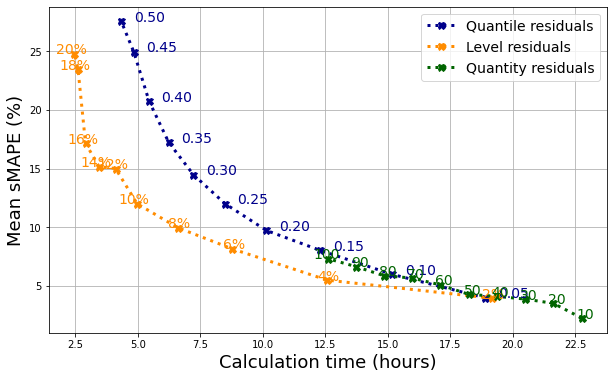

In [110]:
'''With residuals'''
plt.figure(figsize=(10,6))
color=['darkblue', 'darkorange', 'darkgreen']
for k,strategy in enumerate(['Quantile','Level', 'Quantity']):
    if strategy=='Quantile':
        qu=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
        form='%.2f'
    elif strategy=='Level':
        qu=np.arange(2,22,2) # [2.5,5.,7.5,10,12.5,15,17.5, 20, 22.5, 25]
        form='%.0f%%'
    else:
        qu=[10,20,30,40,50,60,70,80,90,100]
        form='%i'
    err, resid=[], []
    for n,q in enumerate(qu):
        labels=mark(q, strategy=strategy) 
        err.append(labels['result'].mean())
        resid.append(labels[labels.level==5]['score4'].mean())
    acc_time=make_acc_time(strategy)
#    plt.plot(acc_time.time/t_unit, err, marker='*', markersize=10, lw=3, label=strategy+' strategy', c=color[k])
    plt.plot(acc_time.time/t_unit, resid, marker='X', markersize=7, lw=3, label=strategy+' residuals', c=color[k], ls=':')
    for i, xy in enumerate(zip(acc_time.time.values/t_unit+.5, np.array(resid))):
        ha='right' if k else 'left'
        plt.text(xy[0],xy[1], form%qu[i], size=14, ha=ha, c=color[k])
    #plt.xticks(acc_time.index, acc_time.quant)
if t_unit==1:
    plt.xlabel('Calculation time (seconds)', size=18)
elif t_unit==60:
    plt.xlabel('Calculation time (minutes)', size=14)
else: 
    plt.xlabel('Calculation time (hours)', size=18)
plt.ylabel('Mean sMAPE (%)', size=18)
#plt.title('sMAPE on time for strategies (with residuals\' sMAPE)', size=16)
plt.legend(fontsize=14)
plt.grid()
#plt.savefig('newpic/LSTM_acc_time_res.png', dpi=300, format='png' )
plt.show()

In [41]:
acc_time

,quant,time,residual,score0,score1,score2,score3,score4,score5,score6,score7,score8,score9,worst
0,10,81929.253703,50,0.971769,0.855671,0.828973,0.799329,0.993908,1.136514,1.316975,1.484798,1.515279,1.493151,2.467173
1,20,77863.844162,100,1.133419,1.013951,1.218768,1.238682,1.432585,1.755974,1.958742,2.062559,2.106261,2.2648,3.165664
2,30,73798.434622,150,1.247521,1.306656,1.54025,1.710732,1.788961,2.074513,2.368286,2.497127,2.837238,3.195624,3.906103
3,40,69733.025081,200,1.350639,1.463287,1.740843,2.003953,2.177985,2.463421,2.74409,3.076452,3.196207,4.072263,4.505754
4,50,65667.615541,250,1.449005,1.601358,2.019352,2.286363,2.461017,2.93595,3.219798,3.693815,4.093348,4.93981,5.12212
5,60,61602.206,300,1.536182,1.724708,2.237126,2.518333,2.773155,3.423568,3.859643,4.434458,4.877166,5.805887,5.894428
6,70,57536.79646,350,1.611581,1.888004,2.356148,2.749889,3.173546,4.011949,4.344215,5.377641,5.945285,7.391788,6.757051
7,80,53471.386919,400,1.675285,2.0489,2.493706,3.044123,3.528054,4.338796,5.273845,6.355695,7.721287,9.532102,7.832054
8,90,49405.977379,450,1.738184,2.151536,2.71038,3.35609,3.925628,4.987898,6.002208,7.760994,9.374967,13.295783,9.440497
9,100,45340.567838,500,1.802989,2.314987,2.901069,3.630555,4.416021,5.535987,6.991063,9.454519,13.075681,27.512312,12.66097


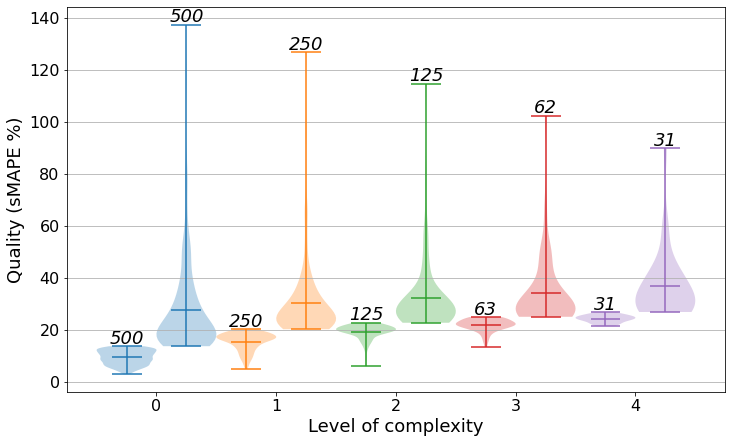

In [13]:
'''Pears for the seive'''
strategy='quant'
quant=.50
quality=[10.0]*5
plt.figure(figsize=(10,6))
lab=labels.copy()
for i in range(5):
    col='score%i'%i
    if strategy=='quant':
        b=np.quantile(lab[col].values, quant)
    else:
        b=quality[i]
    l1=lab[lab[col]<=b][col]  
    l2=lab[lab[col]>b][col]
    if len(l1)==0:
        l1=[10]
    else: lab=lab.drop(l1.index)
    if len(l2)==0:
        l2=[0]
    
    plt.violinplot((l1, l2), positions=[i-.25, i+.25], showmeans=True)
    plt.text(i-.25, max(l1)+1, str(len(l1)), horizontalalignment='center', style='italic', size=18)
    plt.text(i+.25, max(l2)+1, str(len(l2)), horizontalalignment='center', style='italic', size=18)
#plt.axhline(10, ls='-.', c='orange', label='10% bound')
plt.xticks(np.arange(5), np.arange(5), size=16)
plt.yticks(size=16)
plt.xlabel('Level of complexity', size=18)
plt.ylabel('Quality (sMAPE %)', size=18)
#plt.violinplot(labels[labels.level==5].score4, positions=[5])
plt.grid(axis='y')
#plt.legend(fontsize=16, loc=2)
plt.tight_layout(pad=0.1)
#plt.savefig('RF_quant50.png', dpi=300, format='png' )
plt.show()